Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

In [2]:
def plot_data(X,y,ax,title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

Define layer name

In [3]:
folder_name = 'label_10'

Label 02

In [4]:
cols = list(pd.read_csv(f"{folder_name}/train.csv", nrows=1))
train_data = pd.read_csv(f"{folder_name}/train.csv",usecols =[i for i in cols if i not in ["label_1", "label_3", "label_4"]])
train_data.shape

(28520, 769)

Handling missing values

In [5]:
train_data = train_data.dropna()
print(train_data.shape)
train_data.head()

(28040, 769)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_2
480,0.053179,0.094833,-0.098983,0.131190,-0.031974,-0.049086,0.038929,0.091135,-0.107005,0.018532,...,-0.008309,0.096050,-0.319057,-0.084282,0.057429,-0.064677,0.017584,-0.007926,-0.144536,25.0
481,0.033278,0.059124,-0.020353,0.168918,0.036165,-0.117302,-0.081979,-0.070096,-0.161345,0.106618,...,0.002962,0.003712,-0.235858,-0.051955,0.121809,0.007508,0.074416,0.000140,0.115385,25.0
482,0.046853,0.076299,-0.012859,0.089680,0.046729,-0.000054,-0.045814,0.023595,-0.104441,0.025995,...,0.027111,0.087195,-0.142816,-0.202896,0.099567,-0.069376,0.061420,0.003834,0.000445,25.0
483,0.001946,0.060066,0.012458,0.001349,-0.057288,-0.219725,0.001473,0.036990,-0.210818,0.055353,...,0.013749,-0.041319,-0.207143,-0.175213,-0.030503,-0.081459,0.106127,0.039627,0.025073,25.0
484,0.046541,0.113568,-0.009204,0.058154,0.027733,-0.095826,0.072213,-0.013832,-0.007329,0.074815,...,0.016530,0.109589,-0.095758,-0.142571,0.081530,-0.058456,-0.049127,-0.061282,0.041392,25.0


numbers of missing values neglegible 

Import test data set

In [6]:
cols = list(pd.read_csv(f"{folder_name}/valid.csv", nrows=1))
valid_data = pd.read_csv(f"{folder_name}/valid.csv",usecols =[i for i in cols if i not in ["label_1", "label_3", "label_4"]])
valid_data.shape

(750, 769)

Handling missing values

In [7]:
valid_data = valid_data.dropna()
valid_data.shape

(736, 769)

In [8]:
#features
X_train = train_data.iloc[:,:-1]
Y_train = train_data.iloc[:,-1]
X_valid = valid_data.iloc[:,:-1]
Y_valid = valid_data.iloc[:,-1]

Standarization

In [9]:
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)

X_train_scaler = robust_scaler.transform(X_train)
X_valid_scaler = robust_scaler.transform(X_valid)

Dimensionality reduction

In [10]:
pca = PCA(0.95)
pca = pca.fit(X_train_scaler)

X_train_pca = pca.transform(X_train_scaler)
X_valid_pca = pca.transform(X_valid_scaler)
X_train_pca.shape

(28040, 270)

oversampling and undersampling

<Axes: title={'center': 'Count of Label_2'}>

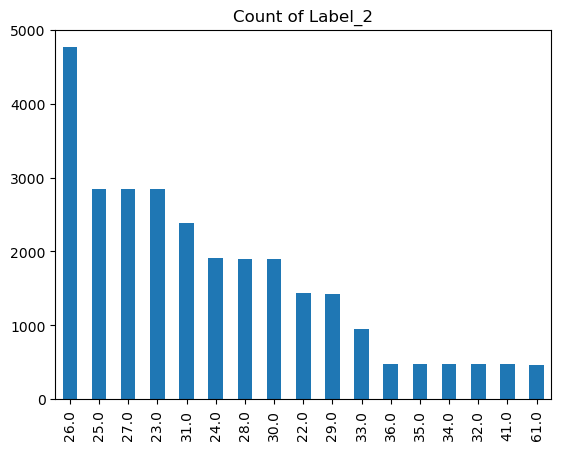

In [11]:
train_data['label_2'].value_counts().plot(kind='bar',title='Count of Label_2')

(80902, 270)


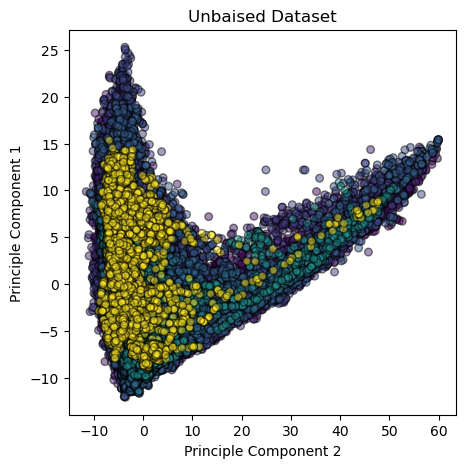

In [12]:
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
# Perform random sampling
smotetomek = SMOTETomek(random_state=0)
X_train_smt, Y_train_smt = smotetomek.fit_resample(X_train_pca, Y_train)
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_smt, Y_train_smt, ax, title='Unbaised Dataset')
print(X_train_smt.shape)

Using SVC

In [13]:
from sklearn.svm import SVC

In [14]:
svc = SVC()
svc.fit(X_train_scaler,Y_train)
svc_predicted = svc.predict(X_valid_scaler)
accuracy_score(Y_valid,svc_predicted)

0.9293478260869565

After feature engineering

In [14]:
svc_fe = SVC()
svc_fe.fit(X_train_smt, Y_train_smt)
svc_predicted = svc_fe.predict(X_valid_pca)
accuracy_score(Y_valid,svc_predicted)

0.936141304347826

Hyper Parameter tuning without dimentionality reduction

In [16]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train_pca, Y_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [17]:
grid.fit(X_train_smt, Y_train_smt)
grid_predictions = grid.predict(X_valid_pca)
  
# print classification report
accuracy_score(Y_valid, grid_predictions)

In [18]:
cols = list(pd.read_csv(f"{folder_name}/test.csv", nrows=1))
test_data = pd.read_csv(f"{folder_name}/test.csv",usecols =[i for i in cols if i not in ["label_1", "label_3", "label_4"]])
#features
X_test = test_data.iloc[:,1:]
X_test.head()

X_test_scaler = robust_scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaler)

grid_predictions = svc_fe.predict(X_test_pca)
grid_predictions

array([22., 25., 30., 27., 29., 30., 27., 33., 23., 22., 26., 25., 27.,
       26., 23., 26., 28., 25., 31., 29., 33., 24., 29., 22., 26., 26.,
       28., 23., 25., 26., 23., 30., 30., 24., 28., 33., 24., 25., 26.,
       25., 23., 23., 25., 30., 31., 22., 26., 32., 25., 23., 22., 24.,
       29., 27., 23., 23., 30., 34., 28., 25., 30., 23., 23., 26., 28.,
       25., 25., 25., 22., 32., 33., 28., 61., 30., 23., 23., 26., 26.,
       27., 26., 34., 32., 23., 23., 23., 28., 31., 23., 26., 23., 22.,
       31., 25., 24., 27., 30., 31., 25., 27., 29., 23., 22., 26., 22.,
       24., 36., 26., 26., 32., 25., 27., 27., 28., 24., 30., 30., 26.,
       25., 23., 26., 27., 26., 41., 33., 32., 28., 29., 35., 34., 24.,
       23., 27., 36., 23., 28., 22., 22., 27., 30., 31., 26., 27., 26.,
       31., 23., 30., 30., 24., 33., 30., 29., 27., 23., 24., 31., 30.,
       23., 25., 28., 41., 31., 25., 25., 28., 30., 26., 30., 26., 26.,
       25., 23., 27., 31., 30., 33., 31., 25., 34., 30., 23., 27

In [19]:
size = grid_predictions.size
index = []
for i in range(size):
    index.append(i+1)
data = {
    'ID': index,
    'label_2': grid_predictions
}
df = pd.DataFrame(data)
df.to_csv('10-2.csv', index=False)

Explainability

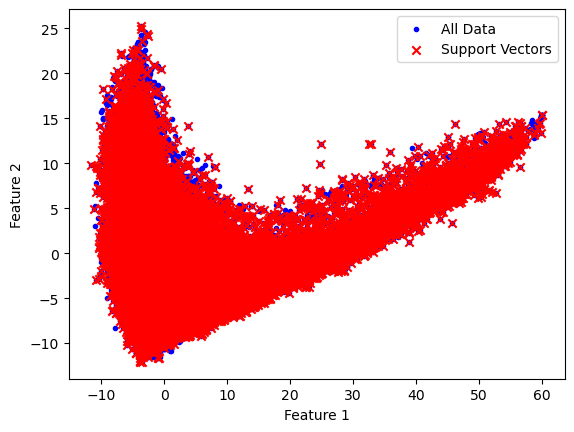

In [15]:
support_vectors = svc_fe.support_vectors_
plt.scatter(X_train_smt[:, 0], X_train_smt[:, 1], c='b', marker='.', label='All Data')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c='r', marker='x', label='Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_valid, svc_predicted)
print(confusion_matrix)

[[ 34   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  65   1   0   3   0   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   4   0  68   4   0   1   0   0   1   0   1   0   0   0   0   0]
 [  0   2   0   1 109   0   0   1   1   1   0   0   0   0   0   0   0]
 [  0   1   0   2   2  73   1   0   0   2   0   0   0   0   0   0   0]
 [  0   0   1   0   1   1  43   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0  44   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0   0  46   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   2   0   0   0  62   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  11   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0  10   0   0   0]
 [  0 

In [17]:
from sklearn.metrics import  classification_report
class_report = classification_report(Y_valid, svc_predicted)
print(class_report)

              precision    recall  f1-score   support

        22.0       0.97      0.94      0.96        36
        23.0       0.86      0.92      0.88        71
        24.0       0.92      1.00      0.96        46
        25.0       0.96      0.86      0.91        79
        26.0       0.89      0.95      0.92       115
        27.0       0.96      0.90      0.93        81
        28.0       0.91      0.93      0.92        46
        29.0       0.98      0.98      0.98        45
        30.0       0.98      0.96      0.97        48
        31.0       0.94      0.95      0.95        65
        32.0       1.00      1.00      1.00        11
        33.0       0.97      1.00      0.98        30
        34.0       1.00      0.91      0.95        11
        35.0       1.00      0.91      0.95        11
        36.0       1.00      1.00      1.00         8
        41.0       1.00      0.79      0.88        14
        61.0       1.00      1.00      1.00        19

    accuracy              

In [18]:
np.corrcoef(X_train_smt,rowvar=False)

array([[ 1.        , -0.00345277, -0.01175674, ..., -0.01161576,
        -0.01443532, -0.02036848],
       [-0.00345277,  1.        ,  0.0208155 , ...,  0.02805635,
        -0.00890143, -0.01073889],
       [-0.01175674,  0.0208155 ,  1.        , ...,  0.00670941,
        -0.00576937, -0.02259123],
       ...,
       [-0.01161576,  0.02805635,  0.00670941, ...,  1.        ,
         0.00255473,  0.0146486 ],
       [-0.01443532, -0.00890143, -0.00576937, ...,  0.00255473,
         1.        ,  0.00178294],
       [-0.02036848, -0.01073889, -0.02259123, ...,  0.0146486 ,
         0.00178294,  1.        ]])